# **Tackle Imbalanced Data Challenge**


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions: 


| Task Name     | Class Ratio (Negative vs. Positive)  |
| ------------- |:-------------:|
| _Credit Card Fraud Detection_      | ~1000 : 1      | 
| _Predicting Customer Churn_ | ~5 : 1      | 
| _Tumor Type Estimation_ | ~2 : 1     | 
| _Predicting Job Change_ | ~10 : 1      | 


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:
- Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
- Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


* Identify typical patterns of imbalanced data challenges
* Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
* Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
* Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


----


First, let us import the required packages for this lab:


In [68]:
# !pip install imbalanced-learn

In [69]:
## Import packages here
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

## Some utility model training and evaluation methods 


Before we continue with more imbalanced classification scenarios, let's define some utility methods for you to simplify this lab and increase notebook readability. A method to define and train a logistic regression:


In [70]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs, 
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to define and train a random forest:


In [71]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to evaluate a classifier's predictions


In [72]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

In [73]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

A method to resample the original dataset


In [74]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

And a method to visualize metrics


In [75]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Scenario: Predicting Customer Churn


In the second scenario, we will be predicting customer churns (leaving the business) of a telecom company.


First, let's read the dataset


In [76]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)

In [77]:
churn_df.head()


,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


This dataset is processed and contains features about a customer's telcom service types, tenure, charges, and payments. Based on such features, we would like to predict if a customer is leaving the business or not (churn).


Then, we need to split the data into training and testing datasets,


In [78]:
X_train, X_test, y_train, y_test = split_data(churn_df)

and take a look at its class distribution.


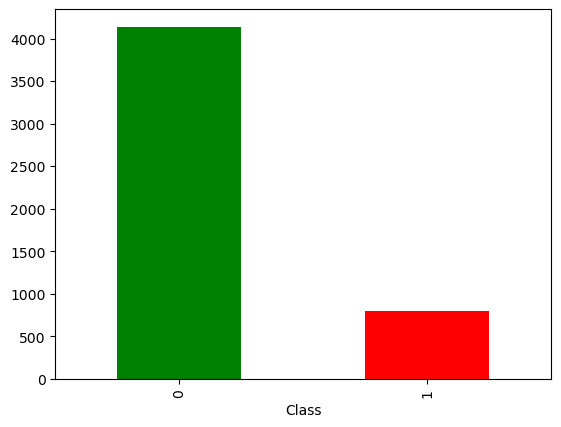

In [79]:
y_train.value_counts().plot.bar(color=['green', 'red']);

As we can see from the bar chart above, the non-churn customers are almost 4 times more than the churn customers, which makes it an imbalanced dataset as well. Since this dataset has 42 features, it would be better to use a more complex classification model and we choose to use `RandomForestClassifier` from `sklearn` package.


`RandomForestClassifier` has many hyperparameters that need to be tuned, we have pre-tuned the main parameters for you. You may also use the provided `grid_search_rf()` method to play with hyperparameter tuning yourself.


In [80]:
# Tuned random forest parameters
best_params_no_weight = {'bootstrap':True,
                         'class_weight':None,
                         'max_depth':10,
                         'min_samples_split':5,
                         'n_estimators':50}

Next, since we want to compare the performance of different models, we create a list to contain all model performance metrics.


In [81]:
results = []

### Train a regular random forest classifier


Then, we will train a regular random forest classifier without any add-ons (class weights or resampling).


In [82]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)

result = evaluate(y_test, preds, "original")
result


{'type': 'original',
 'accuracy': 0.8623481781376519,
 'recall': 0.28,
 'auc': 0.6274396135265701,
 'precision': 0.6829268292682927,
 'fscore': 0.2865013774104683}

In [83]:
results.append(result)

As you may expect, we have a very high prediction `accuracy` but even using a random forest classifier, our `recall` is very low with only 0.28. 
Next, let's try the class reweighting method to see if we can improve the performance.


### Add class re-weighting


We will add class weights to the random forest classifier with pre-tuned weight 0.8 to churn class and weight 0.2 to non-churn class.


In [84]:
class_weight = {}
# 0.2 to Non-churn class
class_weight[0] = 0.2
# 0.8 to Churn class
class_weight[1] = 0.8

In [85]:
# Pre-tuned hyper parameters
best_params_weight = {'bootstrap': True,
                         'class_weight': class_weight, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

Build a random forest model with the class weight 0.8 vs. 0.2.


In [86]:
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)


Then evaluate the refined model.


In [87]:
result = evaluate(y_test, preds_cw, "Class Weight")
print(result)
results.append(result)

{'type': 'Class Weight', 'accuracy': 0.8137651821862348, 'recall': 0.62, 'auc': 0.7356038647342995, 'precision': 0.4460431654676259, 'fscore': 0.6108374384236454}


As we can see from the evaluation results above, `Recall` and `Fscore` are significantly improved by adding class weights. Such improvements indicate that class reweighting is effective for the imbalanced customer churn dataset.


### Resampling: SMOTE and Undersampling


Then, we want to use resampling to see if it is also able to improve the model performance.


First, we create resampled training datasets:


In [88]:
from imblearn.over_sampling import RandomOverSampler, SMOTE


In [89]:
# X_smo is resampled from X_train using SMOTE
# y_smo is resampled from y_train using SMOTE
# X_under is resampled from X_train using Undersampling
# y_under is resampled from y_train using Undersampling
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Then we can retrain a random forest classifier using SMOTE resampled input `X_smo` and output `y_smo` and evaluate its performance,


In [96]:
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
print(result)
results.append(result)

{'type': 'SMOTE', 'accuracy': 0.8396761133603239, 'recall': 0.525, 'auc': 0.7127415458937197, 'precision': 0.5048076923076923, 'fscore': 0.5241935483870968}


and we can retrain a random forest classifier using the undersampled input `X_under` and output `y_under` and evaluate its performance.


In [97]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
print(result)
results.append(result)

{'type': 'Undersampling', 'accuracy': 0.7336032388663968, 'recall': 0.79, 'auc': 0.7563526570048309, 'precision': 0.3550561797752809, 'fscore': 0.7544536271808999}


### Compare the performance among different random forest models


By now, we have built four different random forest models: the model trained with the original dataset, the model with class weights, the model trained with SMOTE dataset, and the model trained with undersampling. 

To better analyze and compare their performance, we can visualize the metrics using a grouped bar chart.


            type  accuracy  recall       auc  precision    fscore
0       original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.839676   0.525  0.712742   0.504808  0.524194
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


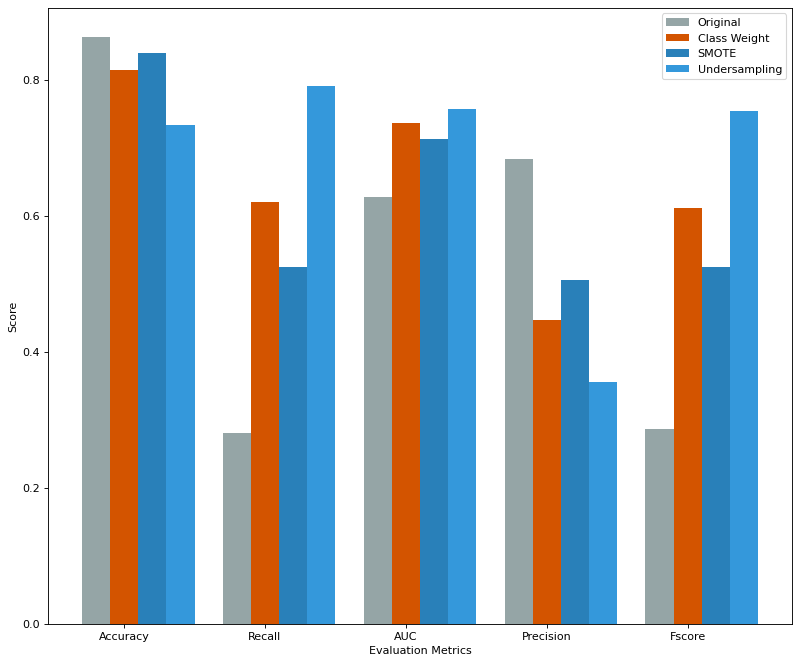

In [98]:
visualize_eval_metrics(results)


Let's first see what each color means. The grey bars represent the original model, the orange bars represent the model with class weight, the dark blue bars represent model trained with SMOTE, and the light blue bars represent the model trained with undersampling.

As we can infer the following insights from the bar charts:


- All models have high accuracy
- Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
- AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
- Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
- Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore


By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.


## Scenario: Tumor Type Estimation


Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling.


This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

First, like other scenarios, let's load and split the dataset


and check its class distribution:


As we can see, this dataset is not as imbalanced as previous datasets. So that it is possible we dont need to use class reweighting and resampling in order to have good classification performance.


But we still create synthetic datasets with SMOTE and undersampling and class weights to compare their performance.


Use tuned random forest parameters.


Train and evaluate different random forest models on the tumor type dataset.


As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.


## Exercise: Predicting Job Change


Now it is time to apply what you have learned in this lab. We have an imbalanced HR dataset and we want to use it to build a classification model to predict if an employee is looking for a new job or not.


### Check its class distribution


In [90]:
# type your code here

### Split the dataset


In [91]:
# type your code here

### Build a logistic regression model with the original dataset


In [92]:
# type your code here

### Add class weights to the model


In [93]:
# type your code here

### Improve the model with SMOTE resampled dataset


In [94]:
# type your code here

### Improve the model with Undersampling resampled dataset


In [95]:
# type your code here

<details><summary>Click here for a solution</summary>

```python
y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")
#metrics.plot_roc_curve(smote_model, X_test, y_test) 
results.append(result)
visualize_eval_metrics(results)
```

</details>


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


<!--## Change Log--!>


<!--|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-9-23|1.0|Yan|Created the initial version||2022-2-23|1.2|Steve Hord|QA pass|--!>


Copyright © 2021 IBM Corporation. All rights reserved.
